In [ ]:
# SGD

reading dataset...
applying feature engineering...
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 7354.5480198255045
Epoch is: 2 and Cost is: 6563.456563217771
Epoch is: 4 and Cost is: 5525.17897154388
Epoch is: 8 and Cost is: 3848.753742497295
Epoch is: 16 and Cost is: 2706.4872104493147
Epoch is: 32 and Cost is: 1971.8196957987477
Epoch is: 64 and Cost is: 1619.5111449169272
Epoch is: 128 and Cost is: 1324.7505213945446
Epoch is: 256 and Cost is: 1161.1820991319796
Epoch is: 512 and Cost is: 1073.3267021416393
Epoch is: 1024 and Cost is: 1047.305229229971
Epoch is: 2048 and Cost is: 1042.1310323688028
Epoch is: 4096 and Cost is: 1043.0128935931746
Epoch is: 4999 and Cost is: 1040.0907952377888
4999
training finished.
testing the model...
accuracy on test dataset: 0.9912280701754386
recall on test dataset: 0.9767441860465116
precision on test dataset: 1.0
4999


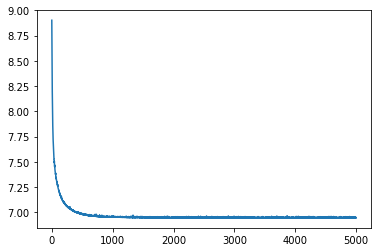

In [44]:
'''Stochastic Gradient Descent'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw


def sgd(features, outputs):
    # Is this SGD? - This may be GD. SGD should go faster
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    errors = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        # this is where need to change code for coordinate gradient descent
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        # Getting the costs for each epoch for the plot
        error = compute_cost(weights, features, outputs)
        errors.append(error)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            #if abs(prev_cost - cost) < cost_threshold * prev_cost:
             #   return weights, errors
            prev_cost = cost
            nth += 1
    print(len(errors))
    return weights, errors

########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    W, errors = sgd(X_train.to_numpy(), y_train.to_numpy())
    
    
    print("training finished.")
    #print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    
    print(len(errors))
    # Plotting the error vs iteration number
    #plt.plot(range(1, 5000), np.log(errors), label='sgd')
    
    #plt.xlabel('Iteration Number')
    #plt.ylabel('Log(Error)')
    #plt.title('Log(Error) vs. Iteration Number')
    #plt.legend()
    #plt.savefig('logerror_vs_epoch.pdf', dpi=300)
    #plt.show()

    return errors


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_sgd = init()

In [46]:
'''Gradient Descent'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw



def gd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    errors = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        # don't do this for cyclic version
        X, Y = shuffle(features, outputs)
        # use only 1 index for other version
        
        ascent = calculate_cost_gradient(weights, X, Y)

        weights = weights - (learning_rate * ascent)

        # Getting the costs for each epoch for the plot
        error = compute_cost(weights, features, outputs)
        errors.append(error)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            #if abs(prev_cost - cost) < cost_threshold * prev_cost:
             #   return weights, errors
            prev_cost = cost
            nth += 1
    
    return weights, errors






########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    W, errors = gd(X_train.to_numpy(), y_train.to_numpy())
    
    print("training finished.")
    #print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    
    #print(len(errors))
    # Plotting the error vs iteration number
    #plt.plot(range(1, 5000), np.log(errors), label='gd')
    #plt.xlabel('Iteration Number')
    #plt.ylabel('Log(Error)')
    #plt.title('Log(Error) vs. Iteration Number')
    #plt.legend()
    #plt.savefig('logerror_vs_epoch.pdf', dpi=300)
    #plt.show()

    return errors


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_gd = init()

reading dataset...
applying feature engineering...
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 9991.733872458542
Epoch is: 2 and Cost is: 9983.467761449328
Epoch is: 4 and Cost is: 9966.935589027515
Epoch is: 8 and Cost is: 9933.87144256939
Epoch is: 16 and Cost is: 9867.743943187765
Epoch is: 32 and Cost is: 9735.492118503751
Epoch is: 64 and Cost is: 9471.00116497868
Epoch is: 128 and Cost is: 8942.07003750872
Epoch is: 256 and Cost is: 7885.876002758495
Epoch is: 512 and Cost is: 7107.24009046653
Epoch is: 1024 and Cost is: 6415.967564904075
Epoch is: 2048 and Cost is: 5217.488215584676
Epoch is: 4096 and Cost is: 3599.224242268617
Epoch is: 4999 and Cost is: 3215.111949350505
training finished.
testing the model...
accuracy on test dataset: 0.9298245614035088
recall on test dataset: 0.813953488372093
precision on test dataset: 1.0


In [48]:
'''Cyclic Coordinate Gradient Descent'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw




def ccgd(features, outputs):
    "Cyclic coordinate gradient descent - believe this is currently same as gd"
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    errors = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        # don't do this for cyclic version
        # Doesn't matter for gradient descent, shuffle indices
        X, Y = shuffle(features, outputs)
        # use only 1 index for other version
        
        # Here, randomnly select index for the coordinate descent
        # Make sure go through all examples - whole data for each coordinate - then all coordinates - 1 epoch

        #print(X.shape)
        for ind in range(X.shape[1]):
            ascent = calculate_cost_gradient(weights, X, Y)

            # Maybe need to train this way
            #for ind, x in enumerate(X):
                #ascent = calculate_cost_gradient(weights, x, Y[ind])
                #weights = weights - (learning_rate * ascent)
            
            # Create an array of zeros with the same shape as ascent
            coord_ascent = np.zeros(ascent.shape)

            # Randomly select an index
            #random_index = np.random.randint(0, ascent.shape[0])

            # Maybe check that this is working properly 

            # Set the selected index to the corresponding value from ascent
            coord_ascent[ind] = ascent[ind]

            # Maybe can do it after calculating the ascent?
            # Update ascent for only that coordinate, ascent should be zeros everywhere else
            weights = weights - (learning_rate * coord_ascent)

        # Getting the costs for each epoch for the plot
        error = compute_cost(weights, features, outputs)
        errors.append(error)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            #if abs(prev_cost - cost) < cost_threshold * prev_cost:
             #   return weights, errors
            prev_cost = cost
            nth += 1
    print(len(errors))
    return weights, errors






########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    W, errors = ccgd(X_train.to_numpy(), y_train.to_numpy())
    
    print("training finished.")
    #print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    
    #print(len(errors))
    # Plotting the error vs iteration number
    #plt.plot(range(1, 5000), np.log(errors), label='ccgd')
    #plt.xlabel('Iteration Number')
    #plt.ylabel('Log(Error)')
    #plt.title('Log(Error) vs. Iteration Number')
    #plt.legend()
    #plt.savefig('logerror_vs_epoch.pdf', dpi=300)
    #plt.show()

    return errors


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_ccgd = init()

reading dataset...
applying feature engineering...
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 9991.733872458542
Epoch is: 2 and Cost is: 9983.467761449328
Epoch is: 4 and Cost is: 9966.935589027515
Epoch is: 8 and Cost is: 9933.87144256939
Epoch is: 16 and Cost is: 9867.743943187765
Epoch is: 32 and Cost is: 9735.492118503751
Epoch is: 64 and Cost is: 9471.00116497868
Epoch is: 128 and Cost is: 8942.07003750872
Epoch is: 256 and Cost is: 7885.931536810181
Epoch is: 512 and Cost is: 7103.958580013956
Epoch is: 1024 and Cost is: 6410.3011569397895
Epoch is: 2048 and Cost is: 5207.972669682946
Epoch is: 4096 and Cost is: 3593.606806226996
Epoch is: 4999 and Cost is: 3210.7365305311923
4999
training finished.
testing the model...
accuracy on test dataset: 0.9298245614035088
recall on test dataset: 0.813953488372093
precision on test dataset: 1.0


reading dataset...
applying feature engineering...
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 9991.733872458542
Epoch is: 2 and Cost is: 9983.467761449328
Epoch is: 4 and Cost is: 9966.935589027515
Epoch is: 8 and Cost is: 9933.87144256939
Epoch is: 16 and Cost is: 9867.743943187765
Epoch is: 32 and Cost is: 9735.49211850375
Epoch is: 64 and Cost is: 9471.00116497868
Epoch is: 128 and Cost is: 8942.07003750872
Epoch is: 256 and Cost is: 7885.913292311359
Epoch is: 512 and Cost is: 7103.629699505588
Epoch is: 1024 and Cost is: 6411.005106408665
Epoch is: 2048 and Cost is: 5210.23472547425
Epoch is: 4096 and Cost is: 3594.107362041672
Epoch is: 4999 and Cost is: 3210.990102744459
training finished.
testing the model...
accuracy on test dataset: 0.9298245614035088
recall on test dataset: 0.813953488372093
precision on test dataset: 0.813953488372093


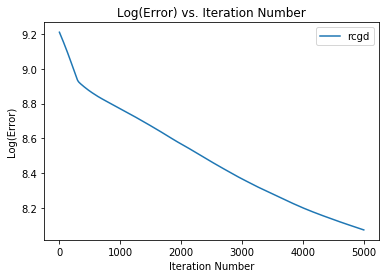

In [24]:
'''Randomized Coordinate Gradient Descent'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw


def rcgd(features, outputs):
    '''Randomized Coordinate descent - potentially this is randomized block coordinate descent'''
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    errors = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        '''Need whole loop through to count as 1 epoch'''
        # shuffle to prevent repeating update cycles
        # don't do this for cyclic version
        # Doesn't matter for gradient descent, shuffle indices - need
        X, Y = shuffle(features, outputs)
        # use only 1 index for other version
        
        # Here, randomnly select index for the coordinate descent

        # for coord in range(X.shape[1]):
        #For ind, x in enumerate x
        #
        # figure out if am doing this for right index here
        shuffled_indices = np.random.permutation(np.arange(0, X.shape[1]))
        
       # test = calculate_cost_gradient(weights, X, Y)
        for ind in shuffled_indices:
            ascent = calculate_cost_gradient(weights, X, Y)
            #print(ascent == test)
            
            
            # Create an array of zeros with the same shape as ascent
            coord_ascent = np.zeros(ascent.shape)

            # Set the selected index to the corresponding value from ascent
            coord_ascent[ind] = ascent[ind]
            #print(coord_ascent)

            # Maybe can do it after calculating the ascent?
            # Update ascent for only that coordinate, ascent should be zeros everywhere else
            #print(weights)
            weights = weights - (learning_rate * coord_ascent)
            #print(weights)
            

        # Getting the costs for each epoch for the plot
        error = compute_cost(weights, features, outputs)
        errors.append(error)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            #if abs(prev_cost - cost) < cost_threshold * prev_cost:
             #   return weights, errors
            prev_cost = cost
            nth += 1
    
    return weights, errors




########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    W, errors = rcgd(X_train.to_numpy(), y_train.to_numpy())
    
    print("training finished.")
    #print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    
    #print(len(errors))
    # Plotting the error vs iteration number
    #plt.plot(range(1, 5000), np.log(errors), label='rcgd')
    #plt.xlabel('Iteration Number')
    #plt.ylabel('Log(Error)')
    #plt.title('Log(Error) vs. Iteration Number')
    #plt.legend()
    #plt.savefig('logerror_vs_epoch.pdf', dpi=300)
    #plt.show()

    return errors


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_rcgd = init()

reading dataset...
applying feature engineering...
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 7091.373046236294
Epoch is: 2 and Cost is: 6744.271297025322
Epoch is: 4 and Cost is: 6020.957533869727
Epoch is: 8 and Cost is: 4564.265017299715
Epoch is: 16 and Cost is: 2865.758439040289
Epoch is: 32 and Cost is: 2091.923842139676
Epoch is: 64 and Cost is: 1628.675606003308
Epoch is: 128 and Cost is: 1344.2323914362944
Epoch is: 256 and Cost is: 1172.379394282882
Epoch is: 512 and Cost is: 1079.6448365681583
Epoch is: 1024 and Cost is: 1047.924045003222
Epoch is: 2048 and Cost is: 1042.7549997400868
Epoch is: 4096 and Cost is: 1041.4951205332031
Epoch is: 4999 and Cost is: 1041.1726327602728
training finished.
testing the model...
accuracy on test dataset: 0.9824561403508771
recall on test dataset: 0.9534883720930233
precision on test dataset: 1.0


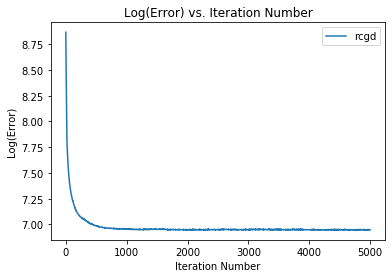

In [49]:
'''Randomized Coordinate Gradient Descent'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw


def rcgd(features, outputs):
    '''Randomized Coordinate descent - potentially this is randomized block coordinate descent'''
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    errors = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        '''Need whole loop through to count as 1 epoch'''
        # shuffle to prevent repeating update cycles
        # don't do this for cyclic version
        # Doesn't matter for gradient descent, shuffle indices - need
        X, Y = shuffle(features, outputs)
        shuffled_indices = np.random.permutation(np.arange(0, X.shape[1]))
        
       # test = calculate_cost_gradient(weights, X, Y)
        for index in shuffled_indices:
            X, Y = shuffle(features, outputs)

            for ind, x in enumerate(X):
                ascent = calculate_cost_gradient(weights, x, Y[ind])
                
                # Create an array of zeros with the same shape as ascent
                coord_ascent = np.zeros(ascent.shape)

                # Set the selected index to the corresponding value from ascent
                coord_ascent[index] = ascent[index]
                
                weights = weights - (learning_rate * coord_ascent)
            

        # Getting the costs for each epoch for the plot
        error = compute_cost(weights, features, outputs)
        errors.append(error)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            #if abs(prev_cost - cost) < cost_threshold * prev_cost:
             #   return weights, errors
            prev_cost = cost
            nth += 1
    
    return weights, errors




########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    W, errors = rcgd(X_train.to_numpy(), y_train.to_numpy())
    
    print("training finished.")
    #print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    
    #print(len(errors))
    # Plotting the error vs iteration number
    plt.plot(range(1, 5000), np.log(errors), label='rcgd')
    plt.xlabel('Iteration Number')
    plt.ylabel('Log(Error)')
    plt.title('Log(Error) vs. Iteration Number')
    plt.legend()
    plt.savefig('logerror_vs_epoch.pdf', dpi=300)
    plt.show()

    return errors


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_rcgd = init()

In [51]:
'''Cyclic Coordinate Gradient Descent'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    print(columns_dropped)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    print(columns_dropped)
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw


def ccgd(features, outputs):
    '''Randomized Coordinate descent - potentially this is randomized block coordinate descent'''
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    errors = []
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        '''Need whole loop through to count as 1 epoch'''
        # shuffle to prevent repeating update cycles
        # don't do this for cyclic version
        # Doesn't matter for gradient descent, shuffle indices - need
        X, Y = shuffle(features, outputs)
        
       # test = calculate_cost_gradient(weights, X, Y)
        for index in range(X.shape[1]):
            X, Y = shuffle(features, outputs)

            for ind, x in enumerate(X):
                ascent = calculate_cost_gradient(weights, x, Y[ind])
                
                # Create an array of zeros with the same shape as ascent
                coord_ascent = np.zeros(ascent.shape)

                # Set the selected index to the corresponding value from ascent
                coord_ascent[index] = ascent[index]
                
                weights = weights - (learning_rate * coord_ascent)
            

        # Getting the costs for each epoch for the plot
        error = compute_cost(weights, features, outputs)
        errors.append(error)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            #if abs(prev_cost - cost) < cost_threshold * prev_cost:
             #   return weights, errors
            prev_cost = cost
            nth += 1
    
    return weights, errors




########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    W, errors = ccgd(X_train.to_numpy(), y_train.to_numpy())
    
    print("training finished.")
    #print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    
    #print(len(errors))
    # Plotting the error vs iteration number
    #plt.plot(range(1, 5000), np.log(errors), label='ccgd')
    #plt.xlabel('Iteration Number')
    #plt.ylabel('Log(Error)')
    #plt.title('Log(Error) vs. Iteration Number')
    #plt.legend()
    #plt.savefig('logerror_vs_epoch.pdf', dpi=300)
    #plt.show()

    return errors


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_ccgd = init()

reading dataset...
applying feature engineering...
Index(['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se',
       'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'concave points_worst'],
      dtype='object')
['smoothness_mean' 'compactness_worst' 'compactness_mean' 'radius_mean'
 'texture_se' 'symmetry_se' 'smoothness_se' 'concavity_worst']
splitting dataset into train and test sets...
training started...
Epoch is: 1 and Cost is: 7580.31194969109
Epoch is: 2 and Cost is: 7034.205059638415
Epoch is: 4 and Cost is: 5970.966173927199
Epoch is: 8 and Cost is: 4299.271097595574
Epoch is: 16 and Cost is: 2811.349649643603
Epoch is: 32 and Cost is: 2049.518449557734
Epoch is: 64 and Cost is: 1608.4344606136726
Epoch is: 128 and Cost is: 1346.7779327167796
Epoch is: 256 and Cost is: 1170.7854387816158
Epoch is: 512 and Cost is: 1079.7341621238122
Epoch is: 1024 and Cost is: 1046.5384066895033
Epoch is: 2048 and Cost is: 1043.43587656679

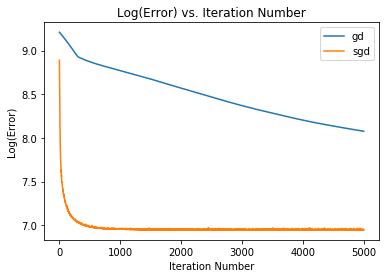

In [40]:
plt.plot(range(1, 5000), np.log(errors_gd), label='gd')
plt.plot(range(1, 5000), np.log(errors_sgd), label='sgd')
plt.xlabel('Iteration Number')
plt.ylabel('Log(Error)')
plt.title('Log(Error) vs. Iteration Number')
plt.legend()
plt.savefig('.png', dpi=300)
plt.show()

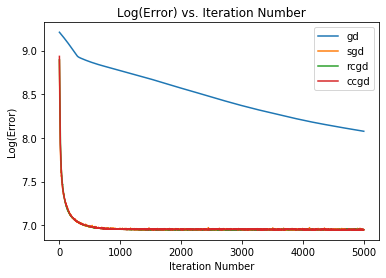

In [42]:
plt.plot(range(1, 5000), np.log(errors_gd), label='gd')
plt.plot(range(1, 5000), np.log(errors_sgd), label='sgd')
plt.plot(range(1, 5000), np.log(errors_rcgd), label='rcgd')
plt.plot(range(1, 5000), np.log(errors_ccgd), label='ccgd')
plt.xlabel('Iteration Number')
plt.ylabel('Log(Error)')
plt.title('Log(Error) vs. Iteration Number')
plt.legend()
plt.savefig('logerror_vs_epoch.png', dpi=300)
plt.show()

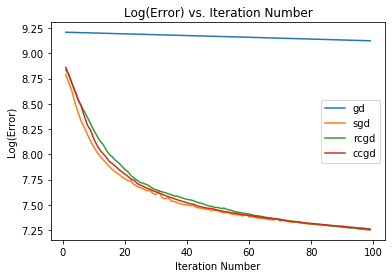

In [38]:
plt.plot(range(1, 100), np.log(errors_gd)[1:100], label='gd')
plt.plot(range(1, 100), np.log(errors_sgd)[1:100], label='sgd')
plt.plot(range(1, 100), np.log(errors_rcgd)[1:100], label='rcgd')
plt.plot(range(1, 100), np.log(errors_ccgd)[1:100], label='ccgd')
plt.xlabel('Iteration Number')
plt.ylabel('Log(Error)')
plt.title('Log(Error) vs. Iteration Number')
plt.legend()
plt.savefig('logerror_vs_epoch100.png', dpi=300)
plt.show()

In [59]:
'''XGBoost'''
import xgboost as xgb
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# >> FEATURE SELECTION << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    print(columns_dropped)
    return columns_dropped


def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    print(columns_dropped)
    return columns_dropped


##############################


# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost


# I haven't tested it but this same function should work for
# vanilla and mini-batch gradient descent as well
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw



########################


def init():
    print("reading dataset...")
    # read data in pandas (pd) data frame
    data = pd.read_csv('./data/data.csv')

    # drop last column (extra column added by pd)
    # and unnecessary first column (id)
    data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

    print("applying feature engineering...")
    # convert categorical labels to numbers
    diag_map = {'M': 1.0, 'B': -1.0}
    data['diagnosis'] = data['diagnosis'].map(diag_map)

    # put features & outputs in different data frames
    Y = data.loc[:, 'diagnosis']
    X = data.iloc[:, 1:]

    # filter features
    remove_correlated_features(X)
    remove_less_significant_features(X, Y)

    # normalize data for better convergence and to prevent overflow
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)

    # insert 1 in every row for intercept b
    X.insert(loc=len(X.columns), column='intercept', value=1)

    # split data into train and test set
    print("splitting dataset into train and test sets...")
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    # train the model
    print("training started...")

    # Define your XGBoost model
    xgb_model = xgb.XGBClassifier()

    # Define the hyperparameters grid to search through
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [100, 300, 500],
        # Add other hyperparameters you want to tune
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Train a new model with the best hyperparameters on the entire training set
    best_xgb_model = xgb.XGBClassifier(**best_params)
    best_xgb_model.fit(X_train, y_train)

    
    print("training finished.")

    # testing the model
    print("testing the model...")

    # Make predictions on the test set using the best model
    y_test_predicted = best_xgb_model.predict(X_test)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
    print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
    print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted)))

    # Convert your data to DMatrix (XGBoost's internal data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Parameters for XGBoost model
    params = {
        'objective': 'binary:logistic',  # Assuming a binary classification task
        'eval_metric': 'logloss',  # Logarithmic loss as evaluation metric
        # Other parameters like max_depth, learning_rate, etc.
    }

    num_rounds = 5000  # Number of boosting rounds or iterations

    # Placeholder to store losses for each iteration
    losses = []

    # Training the XGBoost model
    bst = xgb.train(params, dtrain, num_boost_round=num_rounds,
                evals=[(dtrain, 'train')],
                verbose_eval=False,
                callbacks=[(lambda env: losses.append(env.evaluation_result_list[0][1]), 'logloss')])

    # Print or use the losses list containing loss values after each boosting round
    print("Losses after each boosting round:", losses)

    return losses


# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.000001
errors_xgb = init()


reading dataset...
applying feature engineering...
Index(['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se',
       'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'concave points_worst'],
      dtype='object')
['smoothness_mean' 'compactness_worst' 'compactness_mean' 'radius_mean'
 'texture_se' 'symmetry_se' 'smoothness_se' 'concavity_worst']
splitting dataset into train and test sets...
training started...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
training finished.
testing the model...
accuracy on test dataset: 0.956140350877193
recall on test dataset: 0.9534883720930233
precision on test dataset: 0.9318181818181818


AttributeError: 'tuple' object has no attribute '__dict__'

Index(['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se',
       'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'concave points_worst'],
      dtype='object')
['smoothness_mean' 'compactness_worst' 'compactness_mean' 'radius_mean'
 'texture_se' 'symmetry_se' 'smoothness_se' 'concavity_worst']
Summary Statistics:
        diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean    -0.254833    14.127292     19.289649       91.969033   654.889104   
std      0.967836     3.524049      4.301036       24.298981   351.914129   
min     -1.000000     6.981000      9.710000       43.790000   143.500000   
25%     -1.000000    11.700000     16.170000       75.170000   420.300000   
50%     -1.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000

KeyboardInterrupt: 

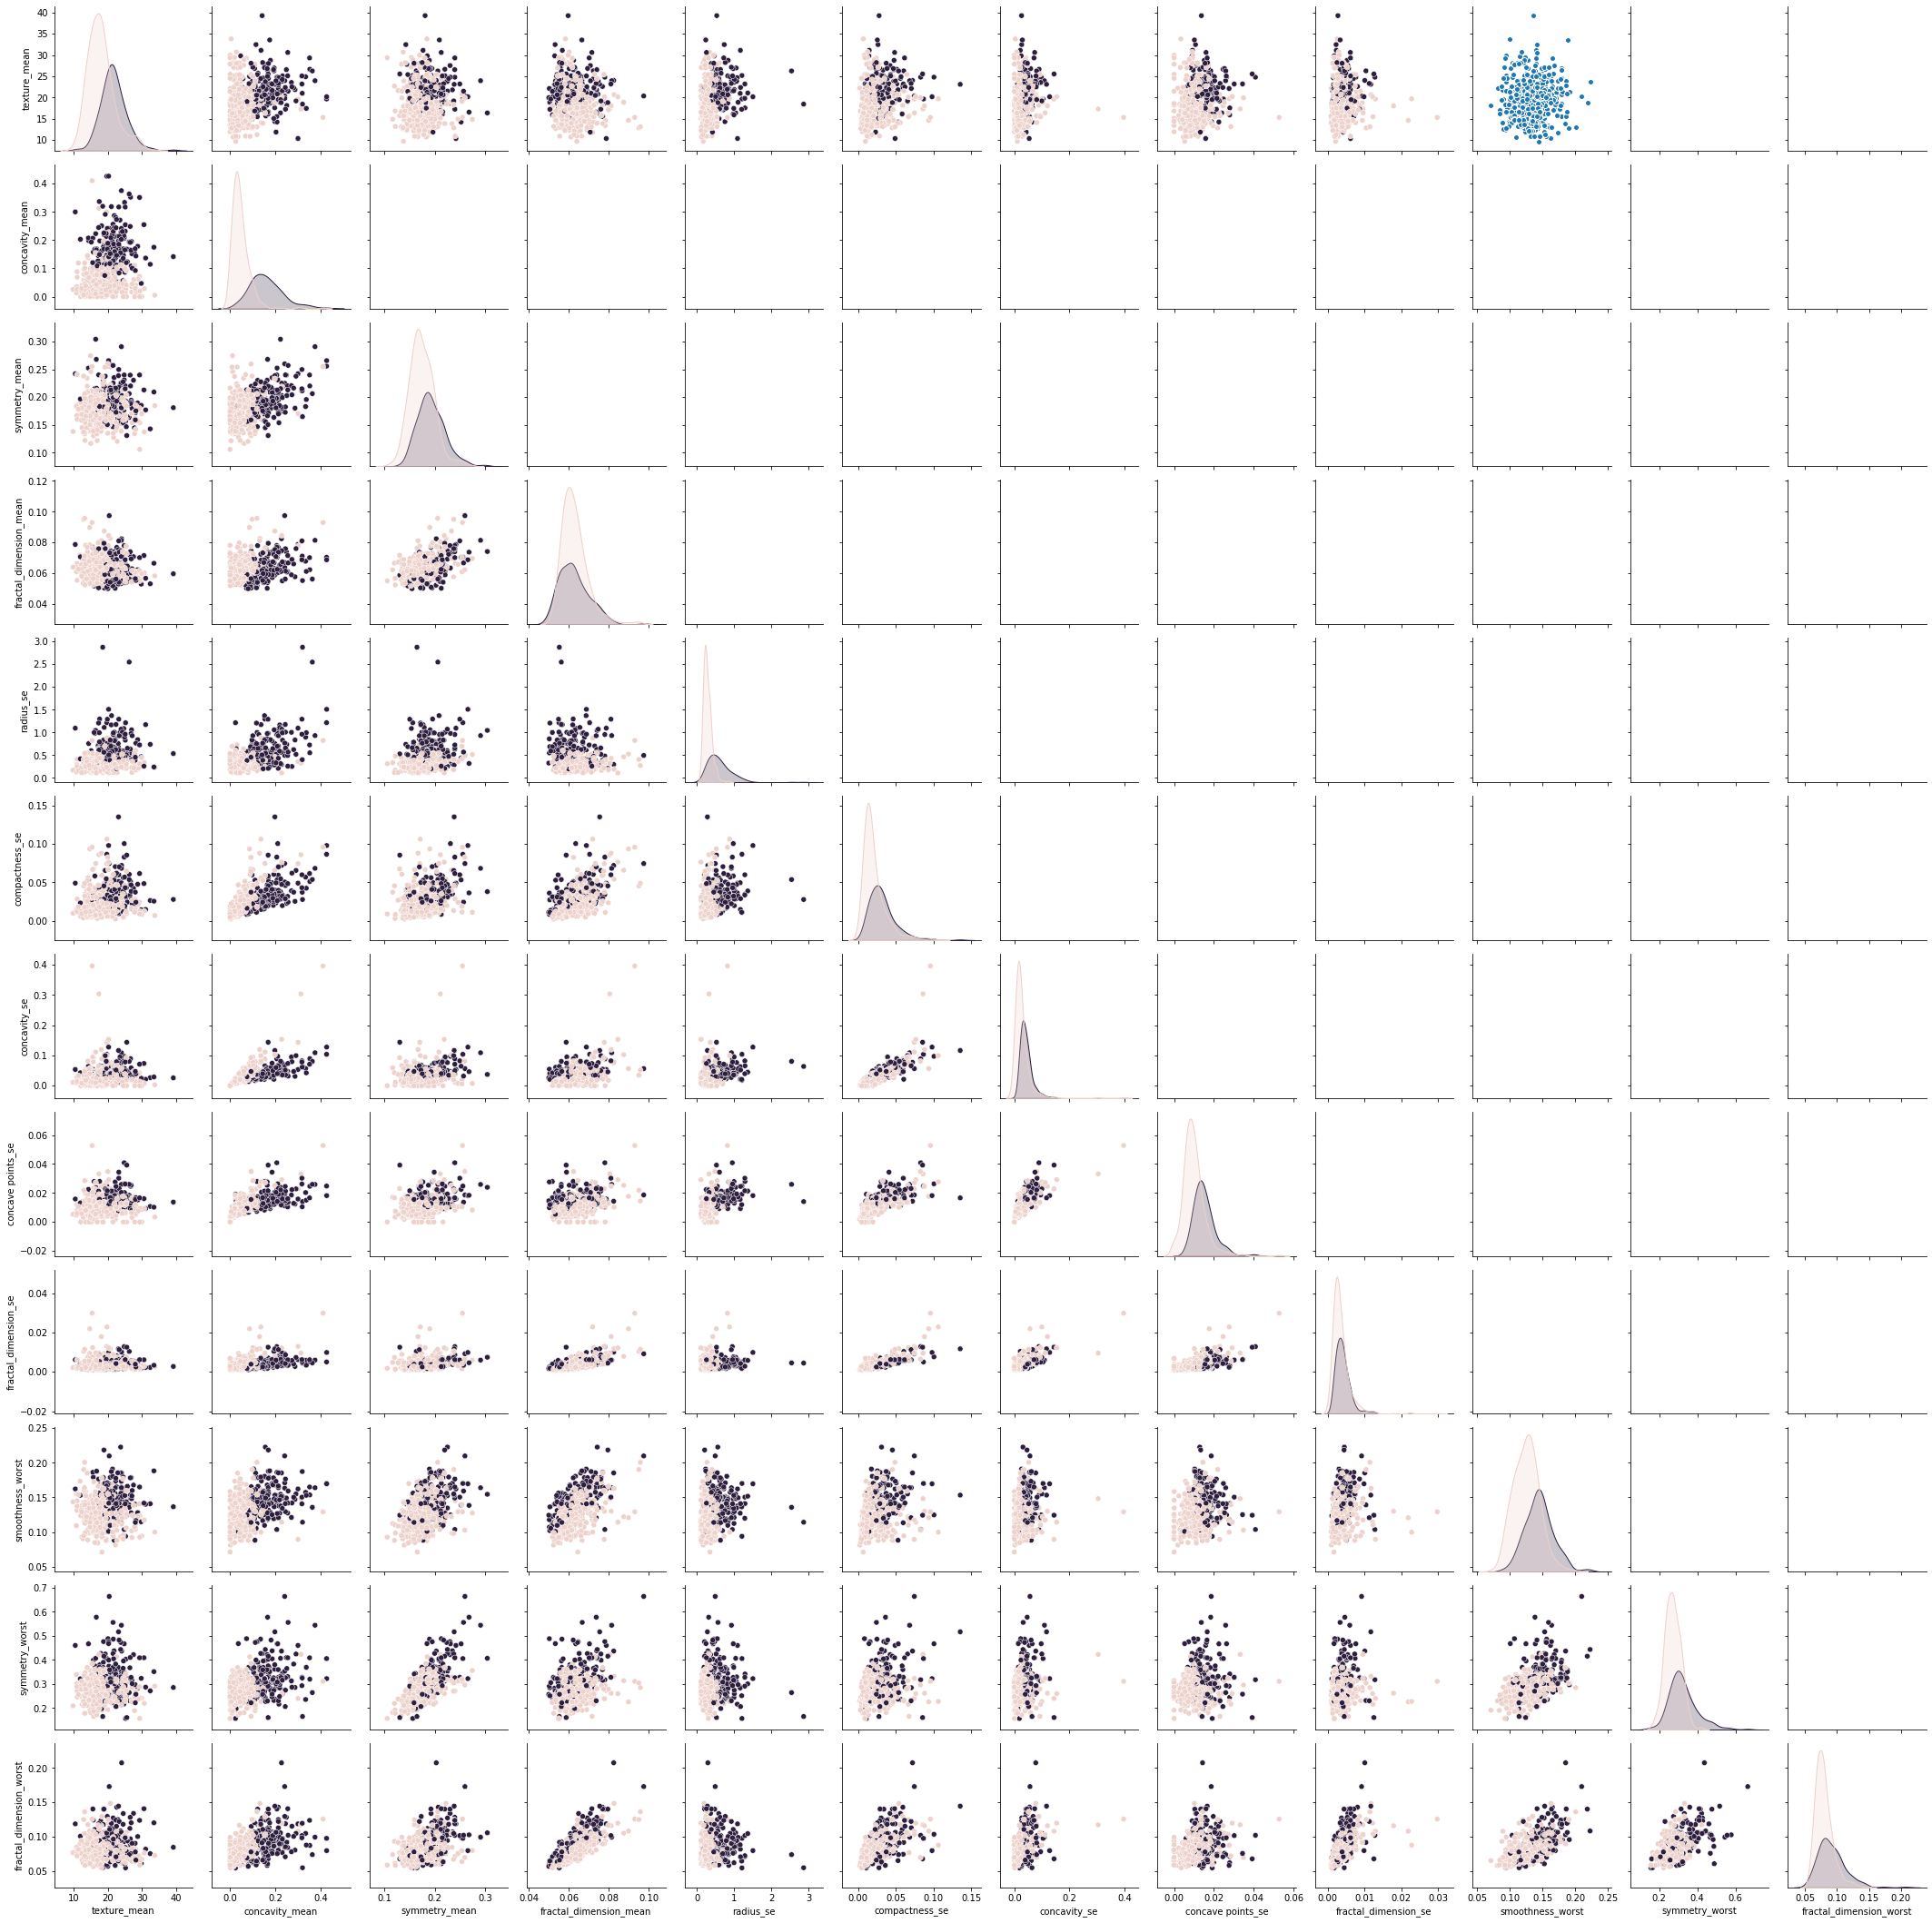

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# read data into a pandas DataFrame
data = pd.read_csv('./data/data.csv')

# drop last column (extra column added by pd)
# and unnecessary first column (id)
data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

# convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': -1.0}
data['diagnosis'] = data['diagnosis'].map(diag_map)

# separate features & outputs
Y = data.loc[:, 'diagnosis']
X = data.iloc[:, 1:]

remove_correlated_features(X)
remove_less_significant_features(X, Y)

print("Summary Statistics:")
print(data.describe())

# Pairplot to visualize relationships between features
sns.pairplot(data, hue='diagnosis', vars=X.columns)
plt.title('Pairplot of Features by Diagnosis')
plt.show()

# Correlation matrix and heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Boxplot of features by diagnosis
plt.figure(figsize=(16, 10))
for i, col in enumerate(X.columns, start=1):
    plt.subplot(5, 6, i)
    sns.boxplot(x='diagnosis', y=col, data=data, palette='viridis')
    plt.title(col)
plt.tight_layout()
plt.show()


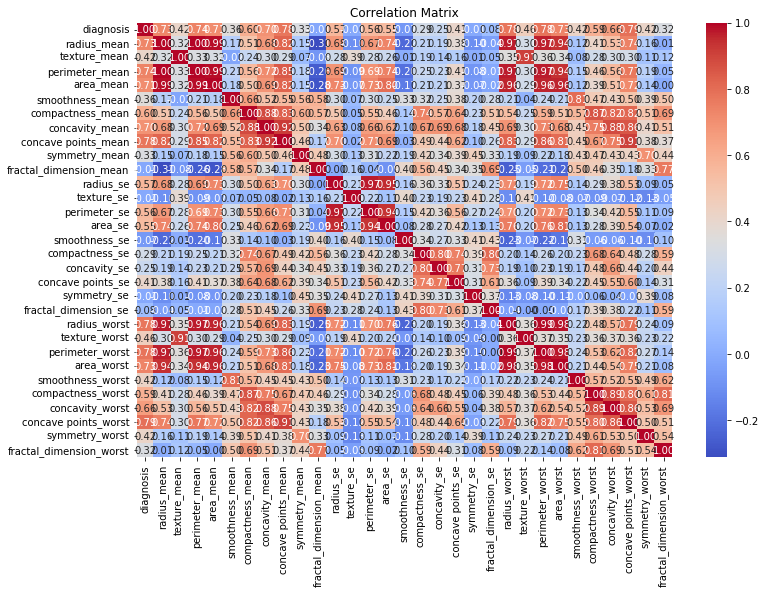

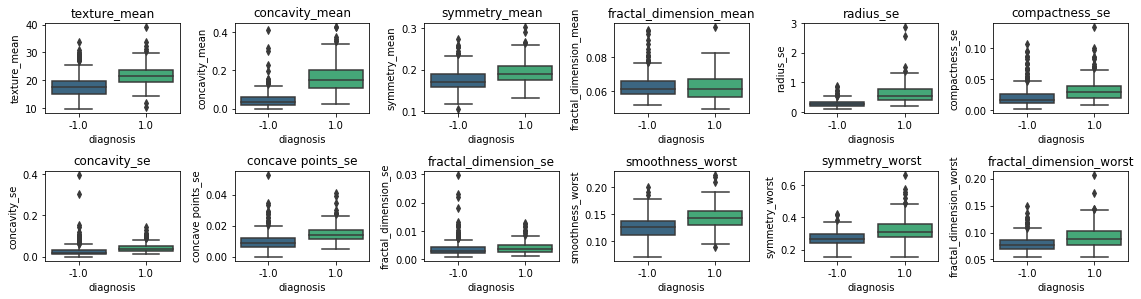

In [63]:
# Correlation matrix and heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Boxplot of features by diagnosis
plt.figure(figsize=(16, 10))
for i, col in enumerate(X.columns, start=1):
    plt.subplot(5, 6, i)
    sns.boxplot(x='diagnosis', y=col, data=data, palette='viridis')
    plt.title(col)
plt.tight_layout()
plt.show()